In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/Users/danielwu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    


In [119]:
print('Load data and select features')
str_exp = '/Users/danielwu/Dropbox/Documents/CSCI5525/Project/'
import os
os.chdir(str_exp)

tadpoleD1D2File = str_exp + 'TADPOLE_D1_D2.csv'

Dtadpole = pd.read_csv(tadpoleD1D2File)

# Create Diagnosis variable based on DXCHANGE
idx_m = Dtadpole['PTGENDER'] == 'Male'
Dtadpole.loc[idx_m, 'PTGENDER'] = 0
idx_f = Dtadpole['PTGENDER'] == 'Female'
Dtadpole.loc[idx_f, 'PTGENDER'] = 1

idx_mci = Dtadpole['DXCHANGE'] == 4
Dtadpole.loc[idx_mci, 'DXCHANGE'] = 2
idx_ad = Dtadpole['DXCHANGE'] == 5
Dtadpole.loc[idx_ad, 'DXCHANGE'] = 3
idx_ad = Dtadpole['DXCHANGE'] == 6
Dtadpole.loc[idx_ad, 'DXCHANGE'] = 3
idx_cn = Dtadpole['DXCHANGE'] == 7
Dtadpole.loc[idx_cn, 'DXCHANGE'] = 1
idx_mci = Dtadpole['DXCHANGE'] == 8
Dtadpole.loc[idx_mci, 'DXCHANGE'] = 2
idx_cn = Dtadpole['DXCHANGE'] == 9
Dtadpole.loc[idx_cn, 'DXCHANGE'] = 1
Dtadpole = Dtadpole.rename(columns={'DXCHANGE': 'Diagnosis'})
h = list(Dtadpole)

D2 = Dtadpole['D2'].copy()

# Select Leaderboard subjects
tadpoleLB1LB2File = str_exp + 'TADPOLE_LB1_LB2.csv'
LB_Table = pd.read_csv(tadpoleLB1LB2File)
LB = LB_Table['LB1'] + LB_Table['LB2']
idx_lb = LB.values >= 1
Dtadpole = Dtadpole[idx_lb]

# Select features
cog_tests_attributes = ["CDRSB", 'EcogPtTotal',
                        'MOCA', "MMSE", "RAVLT_immediate"]
mri_measures = ['Hippocampus', 'WholeBrain',
                'Entorhinal', 'MidTemp', 'Fusiform', 'ICV_bl']
pet_measures = ["FDG", "AV45"]
# csf_measures = ["ABETA_UPENNBIOMK9_04_19_17", "TAU_UPENNBIOMK9_04_19_17", "PTAU_UPENNBIOMK9_04_19_17"]
risk_factors = ["APOE4", "AGE", "PTGENDER"]
values = ['ADAS13', 'Ventricles', 'Diagnosis']

Dtadpole = Dtadpole[['RID'] + values + mri_measures +
                    pet_measures + cog_tests_attributes + risk_factors].copy()
print(Dtadpole.head())
# Force values to numeric
h = list(Dtadpole)

for i in range(5, len(h)):

    if Dtadpole[h[i]].dtype != 'float64':
        Dtadpole[h[i]] = pd.to_numeric(Dtadpole[h[i]], errors='coerce')

# Sort the dataframe based on age for each subject
urid = np.unique(Dtadpole['RID'].values)
Dtadpole_sorted = pd.DataFrame(columns=h)
for i in range(len(urid)):
    agei = Dtadpole.loc[Dtadpole['RID'] == urid[i], 'AGE']
    idx_sortedi = np.argsort(agei)
    D1 = Dtadpole.loc[idx_sortedi.index[idx_sortedi]]
    ld = [Dtadpole_sorted, D1]
    Dtadpole_sorted = pd.concat(ld)
# Save dataset
Dtadpole_sorted.to_csv(
    str_exp + 'IntermediateData/Leaderboard_NeuralNetBagging.csv', index=False)

# Make list of RIDs in D2 to be predicted
idx_lb2 = LB_Table['LB2'] == 1
LB2_RID = LB_Table.loc[idx_lb2, 'RID']
SLB2 = pd.Series(np.unique(LB2_RID.values))
SLB2.to_csv(str_exp + '/IntermediateData/ToPredict.csv', index=False)

# SVM for TADPOLE
print('Train SVM for Diagnosis and SVR for ADAS and Ventricles')
# Read Data
str_in = os.path.join(str_exp, 'IntermediateData',
                      'Leaderboard_NeuralNetBagging.csv')

D = pd.read_csv(str_in)

# Correct ventricle volume for ICV
D = Dtadpole_sorted.copy()
D['Ventricles_ICV'] = D['Ventricles'].values / D['ICV_bl'].values
D['Hippocampus_ICV'] = D['Hippocampus'].values / D['ICV_bl'].values
D['WholeBrain_ICV'] = D['WholeBrain'].values / D['ICV_bl'].values
D['Entorhinal_ICV'] = D['Entorhinal'].values / D['ICV_bl'].values
D['MidTemp_ICV'] = D['MidTemp'].values / D['ICV_bl'].values
D['Fusiform_ICV'] = D['Fusiform'].values / D['ICV_bl'].values
# Get Future Measurements for training prediction
Y_FutureADAS13_temp = D['ADAS13'].copy()
Y_FutureADAS13_temp[:] = np.nan
Y_FutureVentricles_ICV_temp = D['Ventricles_ICV'].copy()
Y_FutureVentricles_ICV_temp[:] = np.nan
Y_FutureDiagnosis_temp = D['Diagnosis'].copy()
Y_FutureDiagnosis_temp[:] = np.nan
RID = D['RID'].copy()
uRIDs = np.unique(RID)
for i in range(len(uRIDs)):
    idx = RID == uRIDs[i]
    idx_copy = np.copy(idx)
    idx_copy[np.where(idx)[-1][-1]] = False
    Y_FutureADAS13_temp[idx_copy] = D.loc[idx, 'ADAS13'].values[1:]
    Y_FutureVentricles_ICV_temp[idx_copy] = D.loc[idx,
                                                  'Ventricles_ICV'].values[1:]
    Y_FutureDiagnosis_temp[idx_copy] = D.loc[idx, 'Diagnosis'].values[1:]
Dtrain = D.drop(['RID', 'Diagnosis', 'Ventricles', 'Hippocampus',
                 'WholeBrain', 'Entorhinal', 'MidTemp', 'Fusiform'], axis=1).copy()

Load data and select features
   RID  ADAS13  Ventricles  Diagnosis  Hippocampus  WholeBrain  Entorhinal  \
0    2   18.67    118233.0        1.0       8336.0   1229740.0      4177.0   
1    3   31.00     84599.0        3.0       5319.0   1129830.0      1791.0   
2    3   30.00     88580.0        3.0       5446.0   1100060.0      2427.0   
3    3   35.00     90099.0        3.0       5157.0   1095640.0      1596.0   
4    3   37.67     97420.0        3.0       5139.0   1088560.0      1175.0   

   MidTemp  Fusiform     ICV_bl      FDG  AV45  CDRSB  EcogPtTotal  MOCA  \
0  27936.0   16559.0  1984660.0  1.36926   NaN    0.0          NaN   NaN   
1  18422.0   15506.0  1920690.0  1.09079   NaN    4.5          NaN   NaN   
2  16972.0   14400.0  1920690.0  1.06360   NaN    6.0          NaN   NaN   
3  17330.0   14617.0  1920690.0  1.10384   NaN    3.5          NaN   NaN   
4  16398.0   14033.0  1920690.0  1.03871   NaN    8.0          NaN   NaN   

   MMSE  RAVLT_immediate  APOE4   AGE  PTGEN

In [120]:
print(Dtadpole['EcogPtTotal'].show_values())

AttributeError: 'Series' object has no attribute 'show_values'

In [9]:
Dtadpole = pd.read_csv(tadpoleD1D2File)

# Create Diagnosis variable based on DXCHANGE
idx_m = Dtadpole['PTGENDER'] == 'Male'
Dtadpole.loc[idx_m, 'PTGENDER'] = 0
idx_f = Dtadpole['PTGENDER'] == 'Female'
Dtadpole.loc[idx_f, 'PTGENDER'] = 1

idx_mci = Dtadpole['DXCHANGE'] == 4
Dtadpole.loc[idx_mci, 'DXCHANGE'] = 2
idx_ad = Dtadpole['DXCHANGE'] == 5
Dtadpole.loc[idx_ad, 'DXCHANGE'] = 3
idx_ad = Dtadpole['DXCHANGE'] == 6
Dtadpole.loc[idx_ad, 'DXCHANGE'] = 3
idx_cn = Dtadpole['DXCHANGE'] == 7
Dtadpole.loc[idx_cn, 'DXCHANGE'] = 1
idx_mci = Dtadpole['DXCHANGE'] == 8
Dtadpole.loc[idx_mci, 'DXCHANGE'] = 2
idx_cn = Dtadpole['DXCHANGE'] == 9
Dtadpole.loc[idx_cn, 'DXCHANGE'] = 1
Dtadpole = Dtadpole.rename(columns={'DXCHANGE': 'Diagnosis'})
h = list(Dtadpole)

D2 = Dtadpole['D2'].copy()

# Select Leaderboard subjects
tadpoleLB1LB2File = str_exp + 'TADPOLE_LB1_LB2.csv'
LB_Table = pd.read_csv(tadpoleLB1LB2File)
LB = LB_Table['LB1'] + LB_Table['LB2']
idx_lb = LB.values >= 1
Dtadpole = Dtadpole[idx_lb]


Datasets: full:        ADAS13     ICV_bl      FDG      AV45  CDRSB  EcogPtTotal  MOCA  MMSE  \
0       18.67  1984660.0  1.36926       NaN    0.0          NaN   NaN  28.0   
5723    19.67  1984660.0  1.21655       NaN    0.0          NaN   NaN  28.0   
5724    20.00  1984660.0      NaN       NaN    0.0          NaN   NaN  29.0   
5725    23.00  1984660.0      NaN       NaN    0.0      1.25641  23.0  28.0   
5726      NaN  1984660.0      NaN       NaN    NaN          NaN   NaN   NaN   
5727    21.00  1984660.0      NaN       NaN    0.0      1.53846  22.0  23.0   
5728      NaN  1984660.0      NaN       NaN    NaN          NaN   NaN   NaN   
5729    14.00  1984660.0      NaN       NaN    1.0      1.33333  23.0  24.0   
5730      NaN  1984660.0      NaN       NaN    NaN          NaN   NaN   NaN   
5731    18.00  1984660.0      NaN       NaN    0.5      1.51282  20.0  25.0   
10836     NaN  1984660.0      NaN       NaN    NaN          NaN   NaN   NaN   
11571     NaN  1984660.0      NaN   

In [21]:
idx_last_Diagnosis = np.isnan(Y_FutureDiagnosis_temp)
Y_FutureDiagnosis = Y_FutureDiagnosis_temp[np.logical_not(
        idx_last_Diagnosis)].copy()
plot_variable_importance(Dtrain,Y_FutureDiagnosis)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [36]:
tadpole_lb1_lb2 = Dtadpole
tadpole_lb1_lb2.head()

,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,EXAMDATE,DX_bl,...,PHASE_UPENNBIOMK9_04_19_17,BATCH_UPENNBIOMK9_04_19_17,KIT_UPENNBIOMK9_04_19_17,STDS_UPENNBIOMK9_04_19_17,RUNDATE_UPENNBIOMK9_04_19_17,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,COMMENT_UPENNBIOMK9_04_19_17,update_stamp_UPENNBIOMK9_04_19_17
0,2,011_S_0002,bl,11,1,1,ADNI1,ADNI1,2005-09-08,CN,...,,,,,,,,,,
1,3,011_S_0003,bl,11,1,0,ADNI1,ADNI1,2005-09-12,AD,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2016-12-14,741.5,239.7,22.83,NaN,2017-04-20 14:39:54.0
2,3,011_S_0003,m06,11,1,0,ADNI1,ADNI1,2006-03-13,AD,...,,,,,,,,,,
3,3,011_S_0003,m12,11,1,0,ADNI1,ADNI1,2006-09-12,AD,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2016-12-14,601.4,251.7,24.18,NaN,2017-04-20 14:39:54.0
4,3,011_S_0003,m24,11,1,0,ADNI1,ADNI1,2007-09-12,AD,...,,,,,,,,,,


In [136]:
tadpole_lb1_lb2["ST14TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"].value_counts()

                      4251
2.701                   12
2.907                   12
2.589                   11
2.665                   11
2.72                    11
2.607                   11
2.693                   10
2.886                   10
2.776                   10
2.8480000000000003      10
2.615                   10
2.591                   10
2.757                    9
2.534                    9
2.77                     9
2.936                    9
2.7060000000000004       9
2.5                      9
2.6069999999999998       9
2.7889999999999997       9
2.804                    9
2.7710000000000004       9
2.63                     9
2.676                    9
2.616                    9
2.971                    9
2.527                    9
2.805                    9
2.807                    9
                      ... 
3.071                    1
3.482                    1
1.831                    1
3.0810000000000004       1
2.968                    1
1.66                     1
2

In [38]:
tadpole_lb1_lb2["DX_bl"].value_counts()

LMCI    4353
CN      3383
EMCI    2319
AD      1568
SMC      389
Name: DX_bl, dtype: int64

In [28]:
tadpole_lb1_lb2["VISCODE"].value_counts()

bl      1737
m06     1618
m12     1485
m24     1326
m18     1293
m36      848
m03      793
m30      750
m48      603
m42      303
m60      264
m72      163
m54      146
m66      138
m78      129
m84      123
m96      100
m108      78
m90       77
m120      33
m102       4
m114       1
Name: VISCODE, dtype: int64

In [40]:
corr_matrix = tadpole_lb1_lb2.corr()
correlations_with_ADAS13 = corr_matrix['ADAS13'].sort_values(ascending=False)
print(correlations_with_ADAS13[:10], correlations_with_ADAS13[-10:])

ADAS13           1.000000
ADAS11           0.981339
ADAS13_bl        0.823384
CDRSB            0.804806
ADAS11_bl        0.782538
FAQ              0.764608
Diagnosis        0.720599
EcogSPTotal      0.711863
EcogSPVisspat    0.689860
EcogSPMem        0.674288
Name: ADAS13, dtype: float64 Hippocampus          -0.545448
FDG_bl               -0.559090
RAVLT_learning       -0.604140
MMSE_bl              -0.627232
FDG                  -0.646439
RAVLT_immediate_bl   -0.680146
MOCA_bl              -0.693297
RAVLT_immediate      -0.790030
MOCA                 -0.838713
MMSE                 -0.838904
Name: ADAS13, dtype: float64


In [41]:
prediction_variables = ["ADAS13", "DX", "Ventricles"]
cog_tests_attributes = ["CDRSB", "ADAS11", "MMSE", "RAVLT_immediate"]
mri_measures = ['Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp' , "FDG", "AV45"]
pet_measures = ["FDG", "AV45"]
csf_measures = ["ABETA_UPENNBIOMK9_04_19_17", "TAU_UPENNBIOMK9_04_19_17", "PTAU_UPENNBIOMK9_04_19_17"]
risk_factors = ["APOE4", "AGE"]

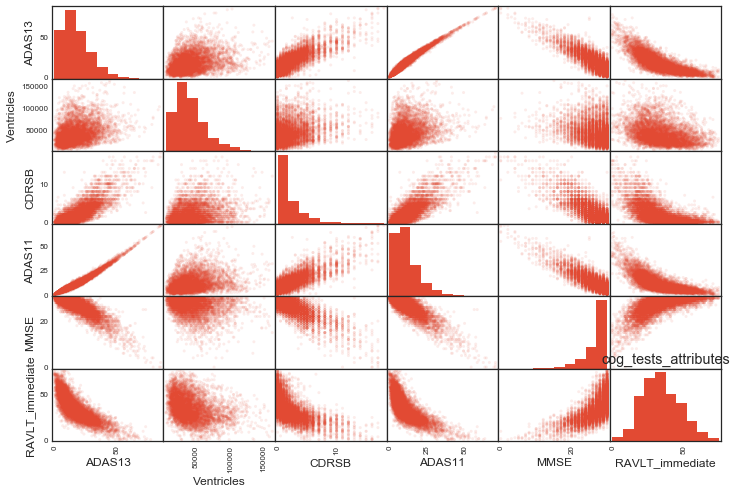

In [42]:
from pandas.plotting import scatter_matrix

scatter_matrix(tadpole_lb1_lb2[prediction_variables+cog_tests_attributes], figsize=(12,8), alpha=0.1)
plt.title("cog_tests_attributes")
plt.show()

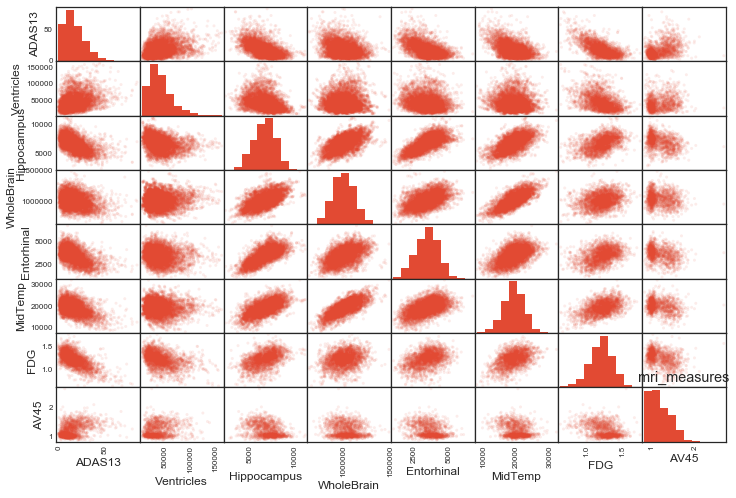

In [34]:
scatter_matrix(tadpole_lb1_lb2[prediction_variables+mri_measures], figsize=(12,8), alpha=0.1)
plt.title("mri_measures")
plt.show()

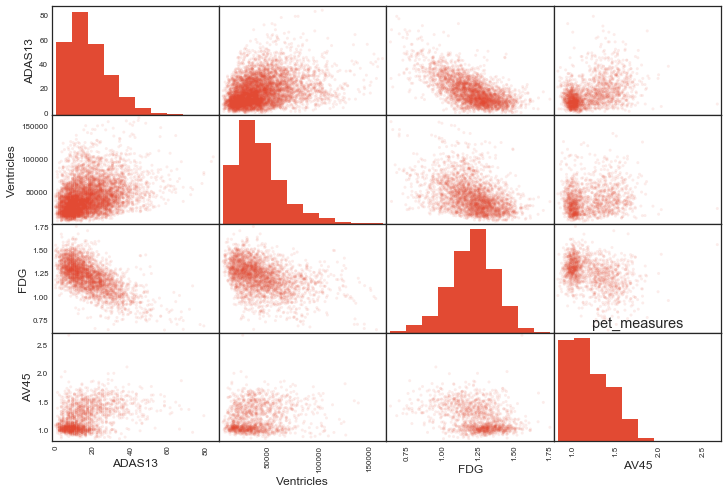

In [35]:
scatter_matrix(tadpole_lb1_lb2[prediction_variables+pet_measures], figsize=(12,8), alpha=0.1)
plt.title("pet_measures")
plt.show()

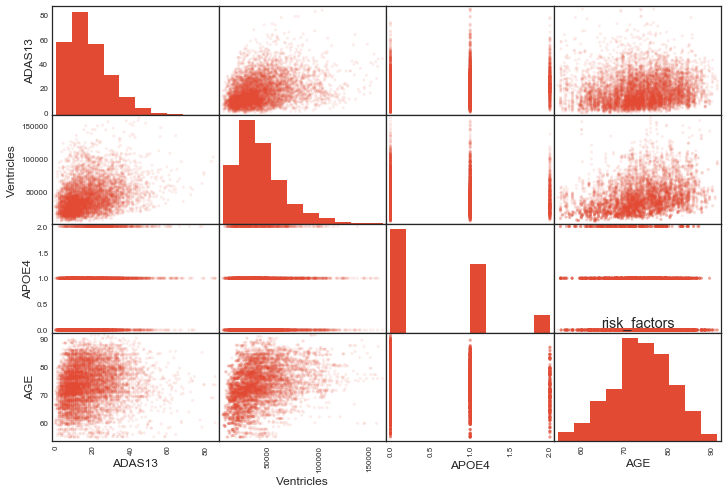

In [43]:
scatter_matrix(tadpole_lb1_lb2[prediction_variables+risk_factors], alpha=0.1, figsize=(12,8))
plt.title("risk_factors")
plt.show()

In [44]:
tadpole_lb1_lb2[tadpole_lb1_lb2['RID'] > 5000].plot(kind="scatter", x="RID", y="AGE_AT_EXAM")

KeyError: 'AGE_AT_EXAM'

In [86]:
cog_tests_attributes = ["CDRSB", "ADAS13", "MMSE", "RAVLT_immediate"]
mri_measures = ['Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp', "Ventricles"]
pet_measures = ["FDG", "AV45"]
csf_measures = ["ABETA_UPENNBIOMK9_04_19_17", "TAU_UPENNBIOMK9_04_19_17", "PTAU_UPENNBIOMK9_04_19_17"]
risk_factors = ["APOE4", "AGE"]

In [113]:
tadpole_lb1_lb2.EXAMDATE = pd.to_datetime(tadpole_lb1_lb2.EXAMDATE)
tadpole_grouped = tadpole_lb1_lb2.groupby("RID").apply(lambda x:(x["EXAMDATE"]-x["EXAMDATE"].min()).dt.days/365.25 + x["AGE"].min())
tadpole_lb1_lb2["AGE_AT_EXAM"] = tadpole_grouped.values

In [87]:
def convert_float(val):
    try:
        return float(val)
    except ValueError:
        return np.nan
for col in csf_measures:
    tadpole_lb1_lb2[col] = tadpole_lb1_lb2[col].map(lambda x:convert_float(x))

In [88]:
useful_numerical_attribs = cog_tests_attributes + mri_measures + pet_measures + csf_measures + ['AGE']
useful_numerical_attribs

['CDRSB',
 'ADAS13',
 'MMSE',
 'RAVLT_immediate',
 'Hippocampus',
 'WholeBrain',
 'Entorhinal',
 'MidTemp',
 'Ventricles',
 'FDG',
 'AV45',
 'ABETA_UPENNBIOMK9_04_19_17',
 'TAU_UPENNBIOMK9_04_19_17',
 'PTAU_UPENNBIOMK9_04_19_17',
 'AGE']

In [89]:
tadpole_lb1_lb2.columns[:20]

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'D1', 'D2', 'COLPROT', 'ORIGPROT',
       'EXAMDATE', 'DX_bl', 'Diagnosis', 'AGE', 'PTGENDER', 'PTEDUCAT',
       'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'PIB'],
      dtype='object')

In [90]:
useful_categorical_attribs = ['RID', 'SITE', 'Diagnosis', 'PTGENDER',
       'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4']
useful_categorical_attribs

['RID',
 'SITE',
 'Diagnosis',
 'PTGENDER',
 'PTEDUCAT',
 'PTETHCAT',
 'PTRACCAT',
 'PTMARRY',
 'APOE4']

In [91]:
tadpole_lb1_lb2[useful_categorical_attribs] = tadpole_lb1_lb2[useful_categorical_attribs].astype(str)

In [92]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index \
in split.split(tadpole_lb1_lb2, tadpole_lb1_lb2[["PTMARRY", "PTGENDER","PTETHCAT"]]):
    strat_train_set = tadpole_lb1_lb2.loc[train_index]
    strat_test_set = tadpole_lb1_lb2.loc[test_index]
tadpole = strat_train_set.copy()    
print(tadpole.head())
print(tadpole_lb1_lb2.head())

print(strat_train_set.keys()[:10])
y_cat_cols = ["Diagnosis"]

       RID        PTID VISCODE SITE   D1   D2 COLPROT ORIGPROT    EXAMDATE  \
6323   NaN         NaN     NaN  NaN  NaN  NaN     NaN      NaN         NaN   
2547  1155  002_S_1155     m18    2  1.0  1.0   ADNI1    ADNI1  2008-08-21   
2479  1118  114_S_1118     m60  114  1.0  0.0   ADNI2    ADNI1  2012-02-21   
1162   498  006_S_0498     m24    6  1.0  1.0   ADNI1    ADNI1  2008-10-02   
6922   476  068_S_0476     m06   68  1.0  0.0   ADNI1    ADNI1  2006-12-06   

     DX_bl                ...                 PHASE_UPENNBIOMK9_04_19_17  \
6323   NaN                ...                                        NaN   
2547  LMCI                ...                                              
2479  LMCI                ...                                              
1162    CN                ...                                              
6922  LMCI                ...                                              

      BATCH_UPENNBIOMK9_04_19_17 KIT_UPENNBIOMK9_04_19_17  \
6323         

In [97]:
#tadpole = strat_train_set.drop(y_num_cols + y_num_cols, axis=1)
tadpole_labels_categorical = strat_train_set[useful_categorical_attribs].copy()
tadpole_labels_continuous = strat_train_set[useful_numerical_attribs].copy()
tadpole = strat_train_set.copy()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer

In [98]:
class LabelBinarizerPipelineFriendly(LabelBinarizer):

    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

In [118]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

  RID  ADAS13  ADAS13  ADAS13  ADAS13  ADAS13  ADAS13  ADAS13  ADAS13  ADAS13  \
0   2   18.67   18.67   18.67   18.67   18.67   18.67   18.67   18.67   18.67   
1   3   31.00   31.00   31.00   31.00   31.00   31.00   31.00   31.00   31.00   
2   3   30.00   30.00   30.00   30.00   30.00   30.00   30.00   30.00   30.00   
3   3   35.00   35.00   35.00   35.00   35.00   35.00   35.00   35.00   35.00   
4   3   37.67   37.67   37.67   37.67   37.67   37.67   37.67   37.67   37.67   

   ...   ADAS13  ADAS13  ADAS13  ADAS13  ADAS13  ADAS13  MMSE  \
0  ...    18.67   18.67   18.67   18.67   18.67   18.67  28.0   
1  ...    31.00   31.00   31.00   31.00   31.00   31.00  20.0   
2  ...    30.00   30.00   30.00   30.00   30.00   30.00  24.0   
3  ...    35.00   35.00   35.00   35.00   35.00   35.00  17.0   
4  ...    37.67   37.67   37.67   37.67   37.67   37.67  19.0   

   RAVLT_immediate  APOE4   AGE  
0             44.0    0.0  74.3  
1             22.0    1.0  81.3  
2             19.0  

In [114]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(useful_numerical_attribs)),
    ('imputer', Imputer(strategy="mean")),
#     ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector([])),
    ('label_binarizer', LabelBinarizerPipelineFriendly()),
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

tadpole_prepared = full_pipeline.fit_transform(tadpole_labels_continuous)

ValueError: Unknown label type: (array([], shape=(9609, 0), dtype=float64),)

In [112]:
lb = LabelBinarizer()
print(tadpole['PTMARRY'])

6323               NaN
2547           Married
2479           Married
1162           Married
6922           Married
3170           Married
1603           Widowed
4143           Married
4295          Divorced
5065           Married
6848           Married
3132           Married
6605           Married
280            Widowed
2032           Married
10383          Married
3688          Divorced
10626          Married
9893           Married
1714          Divorced
8783           Married
6211           Married
10917          Married
1444           Married
8352           Married
8609           Married
8038               NaN
5441          Divorced
9081           Widowed
3275           Married
             ...      
1563           Married
826            Married
1700           Married
4623           Married
6536           Married
3243           Married
1168     Never married
1650          Divorced
1322           Married
2772          Divorced
11532         Divorced
1590           Married
9086       